In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from selenium import webdriver
from nltk.tokenize import word_tokenize
from fuzzywuzzy import fuzz

In [2]:
df_train = pd.read_csv('./train_data.csv')
df_test = pd.read_csv('./test_data.csv')
df_title = pd.read_csv('./title_brand.csv')

/tmp/ipykernel_6594/4039045675.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('./train_data.csv')


<div style="direction:rtl; font-size: 25px; background-color: cyan; color:black; padding:30px 0">  پیش پردازش داده </div>

In [3]:
### Convert to int16 to save memory
df_train['overall'] = df_train['overall'].astype('int16') 
### Convert to datetime type
df_train['reviewTime'] =  pd.to_datetime(df_train['reviewTime'])
df_test['reviewTime'] =  pd.to_datetime(df_test['reviewTime'])
### Drop few rows so that data becomes cleaner (This is a minor change.)
df_train = df_train.dropna(subset=['summary', 'reviewerName', 'style'])
### Sort by datetime (reviewTime column)
df_train.sort_values(by='reviewTime', axis=0, inplace=True, ascending=True)
df_test.sort_values(by='reviewTime', axis=0, inplace=True, ascending=True)
### Max and Min date range
print(f"Max date : {df_train['reviewTime'].max()}")
print(f"Min date : {df_train['reviewTime'].min()}")

### Convert vote column
### For train
df_train['vote'] = pd.to_numeric(df_train['vote'], errors='coerce', downcast='integer')
df_train['vote'] = df_train['vote'].fillna(pd.NA).astype('Int32')
### For test
df_test['vote'] = pd.to_numeric(df_test['vote'], errors='coerce', downcast='integer')
df_test['vote'] = df_test['vote'].fillna(pd.NA).astype('Int32')

### reset index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

Max date : 2018-10-03 00:00:00
Min date : 2016-01-01 00:00:00


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490444 entries, 0 to 490443
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   overall         490444 non-null  int16         
 1   vote            110386 non-null  Int32         
 2   verified        490444 non-null  bool          
 3   reviewTime      490444 non-null  datetime64[ns]
 4   reviewerID      490444 non-null  object        
 5   asin            490444 non-null  object        
 6   style           490444 non-null  object        
 7   reviewerName    490444 non-null  object        
 8   reviewText      490444 non-null  object        
 9   summary         490444 non-null  object        
 10  unixReviewTime  490444 non-null  int64         
dtypes: Int32(1), bool(1), datetime64[ns](1), int16(1), int64(1), object(6)
memory usage: 33.7+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   vote            4933 non-null   Int32         
 1   verified        20000 non-null  bool          
 2   reviewTime      20000 non-null  datetime64[ns]
 3   reviewerID      20000 non-null  object        
 4   asin            20000 non-null  object        
 5   style           11504 non-null  object        
 6   reviewerName    19996 non-null  object        
 7   reviewText      20000 non-null  object        
 8   summary         19998 non-null  object        
 9   unixReviewTime  20000 non-null  int64         
dtypes: Int32(1), bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 1.3+ MB


<div style="direction:rtl; font-size: 25px; background-color: cyan; color:black; padding:30px 0"> بخش ۱) تجزیه و تحلیل اولیه از داده‌ها </div>

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت اول 

<br>
<p>
توزیع ستون overall را رسم کنید. آیا مجموعه‌داده متوازن است؟ اگر خیر، آیا نیاز است برای مدل‌سازی خود آن را متوازن کنید؟ چه راه‌حلی برای این کار پیشنهاد می‌کنید؟
</p>

</div>

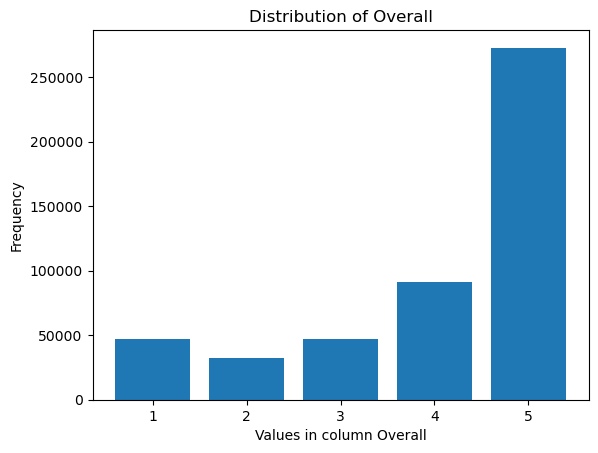

In [6]:
### Plot distrubution of overall column 
overall_values = df_train['overall'].value_counts().sort_index(ascending=False)
plt.xlabel('Values in column Overall')
plt.ylabel('Frequency')
plt.title('Distribution of Overall')
plt.bar(overall_values.index, overall_values.values)
plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت دوم 

<br>
<p>
فرض کنید نظراتی که مقدار ستون overall آن‌ها ۴ یا ۵ است را همراه با حس مثبت، نظراتی که مقدارشان ۳ است را خنثی و نظراتی که مقدارشان ۱ یا ۲ است را حس منفی بدانیم. به‌ازای هر کدام از این سه دسته یک ابر کلمات (Word Cloud) رسم کنید تا بتوان کلمات پرتکرار هر دسته را مشاهده کرد. تا حد ممکن سعی کنید ابر کلمات به‌دست‌آمده شامل اطلاعات مفیدی باشد و کلمات زائد (Stop words) بین آن‌ها وجود نداشته باشد. آیا اشتراکی بین کلمات دسته‌ی مثبت و منفی وجود داشته است؟ چگونه آن‌ها را تفسیر می‌کنید؟
</p>




</div>

In [ ]:
# ### You only need to run this once . Uncomment it again afterwards.
nltk.download('stopwords')

### Define 3 groups
group_labels = {
    4: 'positive-sense',
    5: 'positive-sense',
    3: 'No-sense',
    2: 'negative-sense',
    1: 'negative-sense'
}
### Create a copy just to be sure
df_cloud = df_train.copy()

### Filter the DataFrame based on the custom group labels
df_cloud['group'] = df_cloud['overall'].map(group_labels)

### Just to be sure of results
### Filter out rows with no valid group
df = df_cloud[df_cloud['group'].notna()]

### Define a function to remove stop words from text string
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

### Apply remove_stopwords method to reviewText column
df_cloud['reviewText'] = df_cloud['reviewText'].apply(remove_stopwords)

### Plot word CLoud for each group
for group, data in df_cloud.groupby('group'):
    text = ' '.join(data['reviewText'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {group}')
    plt.axis('off')
    plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت سوم 

<br>
<p>
از بین نظردهندگان، ۱۰ نفری که در مجموع نظرات‌شان بیشتر مفید واقع شده (مجموع vote بیشتری داشته‌اند) را پیدا کنید. نام هر فرد و مجموع vote آن را به‌ترتیب نمایش دهید.
</p>


</div>

In [7]:
top_10_votes = df_train.sort_values(by='vote', ascending=False)
top_10_votes[['reviewerName', 'vote']].head(10)
### We kept original index in case for later reference

,reviewerName,vote
89306,David H,982
145065,VermontGuy,971
114527,Chris Upton,970
207537,Tech Dude,920
122953,R. Voorhees,919
44135,Obi Wan,909
75862,Benson Leung,889
366556,In Depth Reviewer - Xunno,831
49797,JBHorner,822
106372,N. Smith,819


<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت چهارم 

<br>
<p>
هیستوگرام طول متن (تعداد کاراکتر) ستون reviewText را رسم کنید. یک‌بار با حالت اصلی رسم کنید و یک‌بار به‌صورت فیلترشده (آن دسته‌هایی که تعداد نمونه‌های کم و پرتی دارند را در نظر نگیرید) ترسیم کنید. انتخاب تعداد دسته‌ها (bins) برعهده‌ی خودتان است و نمودار خروجی شما باید مناسب و خوانا باشد. آیا نیاز است در هنگام مدل‌سازی محدودیتی روی تعداد کاراکترها بگذاریم؟ اگر بله، بازه‌ی پیشنهادی شما چه عددهایی است؟
</p>

</div>

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> حالت اصلی (بدون فیلتر) </div>

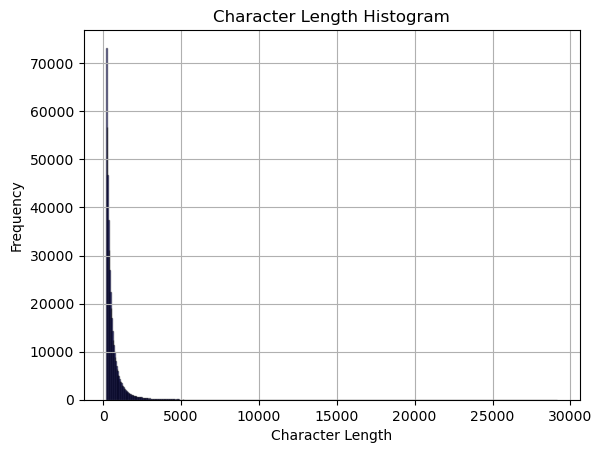

In [8]:
### Calculate bins using square root
num_bins = int(np.sqrt(len(df_train['reviewText'])))
### Plot
plt.hist(df_train['reviewText'].apply(len), bins=num_bins, alpha=0.5, color='b', edgecolor='black')
plt.title('Character Length Histogram')
plt.xlabel('Character Length')
plt.ylabel('Frequency')

plt.grid(True)
plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> بعد از اعمال فیلتر </div>

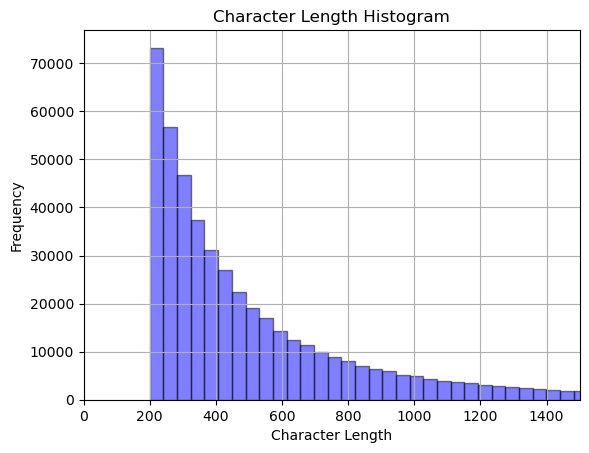

In [9]:
### Calculate bins using square root
num_bins = int(np.sqrt(len(df_train['reviewText'])))
### Plot
plt.hist(df_train['reviewText'].apply(len), bins=num_bins, alpha=0.5, color='b', edgecolor='black')
plt.title('Character Length Histogram')
plt.xlabel('Character Length')
plt.ylabel('Frequency')

### Limit x-axis
plt.xlim(0, 1500)

plt.grid(True)
plt.show()

<div style="direction:rtl; font-size: 25px; background-color: green; color:white;"> با توجه به نمودار هیستوگرام بدست امده ، پیشنهاد میشود محدودیت 1500 تایی برای تعداد کاراکترهای نظرات در نظر گرفته شود چراکه اکثریت نظرات کمتر از این تعداد کاراکتر داشتند.  </div>

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت پنجم 
<br>
<p>
کدام محصولات بیشترین امتیاز ۵ را کسب کرده‌اند؟ ۱۰ مورد برتر را به‌ترتیب به‌صورت یک جدول شامل نام برند، عنوان محصول و تعداد نظرات با امتیاز ۵ نمایش دهید
</p>
</div>

In [13]:
### Groupby product string ID
top_10_products = df_train[df_train['overall'] == 5].groupby('asin').size().reset_index(name='count')
### Sort them by their count 
top_10_products = top_10_products.sort_values(by='count', ascending=False)
top_10_products = top_10_products[:10].reset_index(drop=True)
top_10_products

,asin,count
0,B000VS4HDM,598
1,B00S9SGNNS,471
2,B000WYVBR0,448
3,B00P7EVST6,433
4,B00OAJ412U,430
5,B00DIF2BO2,427
6,B00JX1ZS5O,414
7,B00BWF5U0M,411
8,B003INFE16,400
9,B016XTADG2,400


In [14]:
### Find both brand and title for each product 
### If it exists in df_title.csv
for feature in ['brand', 'title']:
    found_features = []
    for pid in top_10_products['asin']:
        ### If it was found, add its feature
        if pid in df_title['asin'].values:
            found_feature = df_title[df_title['asin'] == pid ][feature].values[0]
            found_features.append(found_feature)
        ### If not found, add NaN instead
        else:
            found_features.append(pd.NA)
    ### Add brands to df
    top_10_products[feature.capitalize()] = found_features
top_10_products

,asin,count,Brand,Title
0,B000VS4HDM,598,StarTech,StarTech USB 2.0 to SATA IDE Adapter (USB2SATA...
1,B00S9SGNNS,471,Asus,ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up...
2,B000WYVBR0,448,VideoSecu,VideoSecu ML531BE TV Wall Mount for Most 27&qu...
3,B00P7EVST6,433,"Arlo Technologies, Inc",Arlo - Wireless Home Security Camera System | ...
4,B00OAJ412U,430,Samsung,Samsung 850 EVO 250GB 2.5-Inch SATA III Intern...
5,B00DIF2BO2,427,Cheetah,Cheetah Mounts APFMSB TV Wall Mount Bracket fo...
6,B00JX1ZS5O,414,Sabrent,Sabrent 4-Port USB 3.0 Hub with Individual LED...
7,B00BWF5U0M,411,Sabrent,Sabrent 4-Port USB 2.0 Hub with Individual Pow...
8,B003INFE16,400,Cooler Master,Cooler Master Vortex Plus - CPU Cooler with Al...
9,B016XTADG2,400,Anker,Anker Soundcore Bluetooth Speaker with Loud St...


<div style="direction:rtl; font-size: 25px; background-color: green; color:black;">  

<p>
این قسمت را به صورت طرح مسیله جدید پیش بردیم و با اسکریپ کردن دیتا مستقیما از وبسایت آمازون ، برند محصولات را بدست اوردیم
</p>

<p>
به جای استفاده از فایل title_data.csv
(طرح مسیله جدید)
</p>


</div>

In [ ]:
from time import sleep
from selenium.webdriver.common.by import By
from webdriver_manager.firefox import GeckoDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

### Path to your selenium driver
# driver_path = '/usr/local/bin/geckodriver'

# driver = webdriver.Firefox(executable_path=driver_path)
# service = Service(executable_path='D:\quera\tamrin\prozhe nahaei\chromedriver.exe')
driver = webdriver.Firefox()
brands_web = []
models_web = []



for product_id in top_10_products["asin"]:
    driver.get(f"https://www.amazon.com/dp/{product_id}")

    ### Model name
    model_name = driver.find_element(By.ID,'productTitle').text

    ### Brand name
    inner_html = "Brand" 
    xpath_expression = f"//span[contains(., '{inner_html}')]"
    span_element = driver.find_element(By.XPATH,xpath_expression)
    parent_element = span_element.find_element(By.XPATH,'..')
    sibling_element = parent_element.find_element(By.XPATH,'following-sibling::*')
    child_element = sibling_element.find_element(By.XPATH,'.//*')
    inner_html = child_element.get_attribute('innerHTML')
    brand_name = inner_html

    try:
        pass
    except NoSuchElementException:
        button = driver.find_element_by_xpath('/html/body/div[1]/header/div/div[4]/div[1]/div/div/div[3]/span[1]/span/input')
        button.click()
    
    brands_web.append(brand_name)
    models_web.append(model_name)

    sleep(3)
driver.quit()

In [ ]:
top_10_products['Brand_web'] = brands_web
top_10_products['Model_web'] = models_web
top_10_products.rename(columns={'asin': 'Product_id', 'count': 'No_5_star_Reviews'}, inplace=True)
top_10_products

<div style="direction:rtl; font-size: 25px; background-color: green; color:black;"> قسمت ششم 

<br>
<p>
ابتدا ۱۰ برندی که بیشترین تعداد نظر را داشته‌اند پیدا کنید. سپس میانگین امتیاز هرکدام را محاسبه کرده و یک جدول شامل نام برند و میانگین امتیاز آن به‌ترتیب میانگین امتیاز نمایش دهید.
</p>

</div>

</div>

In [30]:
### First get top 10 products with most reviews 
top_10_reviews = df_train.groupby(by='asin').agg({'asin': 'count'}).rename_axis('Product_id').sort_values(by='asin', ascending=False)[:10].reset_index()
top_10_reviews.rename(columns={'asin': 'Total_Reviews'}, inplace=True)
### Then calculate average overall rating for top 10 products with most reviews
means = []
for pid in top_10_reviews['Product_id']:
    average = df_train[df_train['asin'] == pid]['overall'].mean()
    means.append(average)
### Add averages to top_10_reviews
top_10_reviews['Mean_Overall'] = means
top_10_reviews

,Product_id,Total_Reviews,Mean_Overall
0,B00P7EVST6,1114,3.657092
1,B00S9SGNNS,905,3.690608
2,B000VS4HDM,793,4.403531
3,B00BUSDVBQ,760,3.730263
4,B00JX1ZS5O,759,4.005270
5,B01BGTG41W,747,3.583668
6,B00DIF2BO2,736,4.177989
7,B006JH8T3S,682,4.102639
8,B000WYVBR0,672,4.316964
9,B003Y5RYNY,670,3.807463


In [31]:
### Get only brand this time. (No title needed)
for feature in ['brand']:
    found_features = []
    for pid in top_10_reviews['Product_id']:
        ### If it was found, add its feature
        if pid in df_title['asin'].values:
            found_feature = df_title[df_title['asin'] == pid ][feature].values[0]
            found_features.append(found_feature)
        ### If not found, add NaN instead
        else:
            found_features.append(pd.NA)
    ### Add brands to df
    top_10_reviews[feature.capitalize()] = found_features
### Sort by Mean_Overall
top_10_reviews.sort_values(by='Mean_Overall', ascending=False,inplace=True)
top_10_reviews.reset_index(drop=True, inplace=True)
top_10_reviews

,Product_id,Total_Reviews,Mean_Overall,Brand
0,B000VS4HDM,793,4.403531,StarTech
1,B000WYVBR0,672,4.316964,VideoSecu
2,B00DIF2BO2,736,4.177989,Cheetah
3,B006JH8T3S,682,4.102639,Logitech
4,B00JX1ZS5O,759,4.005270,Sabrent
5,B003Y5RYNY,670,3.807463,TP-LINK
6,B00BUSDVBQ,760,3.730263,TP-LINK
7,B00S9SGNNS,905,3.690608,Asus
8,B00P7EVST6,1114,3.657092,"Arlo Technologies, Inc"
9,B01BGTG41W,747,3.583668,SanDisk


<div style="direction:rtl; font-size: 25px; background-color: green; color:black;">  

<p>
این قسمت را به صورت طرح مسیله جدید پیش بردیم و با اسکریپ کردن دیتا مستقیما از وبسایت آمازون ، برند محصولات را بدست اوردیم
</p>

<p>
به جای استفاده از فایل title_data.csv
(طرح مسیله جدید)
</p>


</div>

In [ ]:
### Finally get their brands from web
brands_web_2 = []
for p_id in top_10_reviews['Product_id']:
    ### Check to see if we already have the brand name from previous section
    if p_id in top_10_products['Product_id'].values:
        b = top_10_products[top_10_products['Product_id'] == p_id]['Brand'].values[0]
        brands_web_2.append(b)
    else:
        print(f"p_id {p_id} did Not exist. Scraping...\n")
        ### Scrape brand name from web
        ### Path to your selenium driver
        driver_path = '/usr/local/bin/geckodriver'
        
        driver = webdriver.Firefox()
        driver.get(f"https://www.amazon.com/dp/{p_id}")

        ### Brand name
        inner_html = "Brand" 
        xpath_expression = f"//span[contains(., '{inner_html}')]"
        span_element = driver.find_element(By.XPATH,xpath_expression)
        parent_element = span_element.find_element(By.XPATH,'..')
        sibling_element = parent_element.find_element(By.XPATH,'following-sibling::*')
        child_element = sibling_element.find_element(By.XPATH,'.//*')
        inner_html = child_element.get_attribute('innerHTML')
        brand_name = inner_html
        brands_web_2.append(brand_name)


        try:
            pass
        except NoSuchElementException:
            button = driver.find_element_by_xpath('/html/body/div[1]/header/div/div[4]/div[1]/div/div/div[3]/span[1]/span/input')
            button.click()
        sleep(3)
        driver.quit()
### Add brands to top_10_reviews
top_10_reviews['Brand_Web'] = brands_web_2
top_10_reviews

<div style="direction:rtl; font-size: 25px; background-color: cyan; color:black; padding:30px 0"> بخش ۲) میزان رضایت از یک جنبه‌ی مشخص
 </div>

In [ ]:
# nltk.download('popular')
keywords = ["guarantee", "warranty"]
similar_indices = []

for index, text in enumerate(df_train['reviewText']):
    tokens = word_tokenize(text)
    found_similar_word = False  
    for word in tokens:
        for keyword in keywords:
            similarity = fuzz.ratio(word.lower(), keyword)
            if similarity > 80:
                found_similar_word = True
                break  
        if found_similar_word:
            break 
    if found_similar_word:
        similar_indices.append(index)

subset_df = df_train.loc[similar_indices]
subset_df

In [ ]:
import spacy

nlp = spacy.load("en_core_web_md")

target_words = ["warranty", "guarantee"]

word_embeddings = {word: nlp(word).vector for word in target_words}

similar_words = set()

for word, embedding in word_embeddings.items():
    similar_words.update({w for w in nlp.vocab if w.has_vector and w.is_lower and w.similarity(nlp(word)) > 0.8})

relevant_reviews = []

for index, row in df_train.iterrows():
    doc = nlp(row["reviewText"])
    if any(token.text.lower() in similar_words for token in doc):
        relevant_reviews.append((row["asin"], row["overall"]))

average_scores = {}

for asin, score in relevant_reviews:
    if asin not in average_scores:
        average_scores[asin] = []
    average_scores[asin].append(score)

for asin, scores in average_scores.items():
    average_scores[asin] = sum(scores) / len(scores)

for asin, average_score in average_scores.items():
    print(f"ASIN: {asin}, Average Score: {average_score}")


In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Assuming you have df_train with 'reviewText' and 'overall' columns
# Preprocess data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['reviewText'])
total_words = len(tokenizer.word_index) + 1

input_sequences = tokenizer.texts_to_sequences(df_train['reviewText'])
max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')

# Define the model
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_length))
model.add(LSTM(100))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Train the model
model.fit(input_sequences, df_train['overall'], epochs=5)

# Assuming you have df_test with 'reviewText'
input_sequences_test = tokenizer.texts_to_sequences(df_test['reviewText'])
input_sequences_test = pad_sequences(input_sequences_test, maxlen=max_sequence_length, padding='post')

# Predict sentiment
predicted_sentiment = model.predict(input_sequences_test)

# Print predicted sentiment for each review
for i, sentiment in enumerate(predicted_sentiment):
    print(f"Review {i+1} - Predicted Sentiment: {sentiment[0]}")
